In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [10]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [12]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
result = calc_temps('2017-08-01', '2018-08-01')
print(result)

[(70.0, 78.82417582417582, 85.0)]


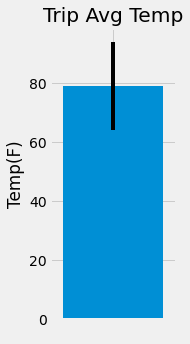

In [13]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(2,5))
plt.bar(x=' ', height = result[0][1], yerr=(result[0][2]-result[0][0]))
plt.title("Trip Avg Temp")
plt.ylabel('Temp(F)')
plt.xlim(-0.5, 0.5)
plt.show()

### Daily Rainfall Average

In [14]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2017-08-01'
end_date = '2018-08-01'
rainfall = session.query(func.sum(Measurement.prcp), Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
rainfall

[(34.65000000000002,
  'USC00516128',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 (5.129999999999995,
  'USC00519281',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 (3.239999999999998,
  'USC00514830',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 (3.0600000000000005,
  'USC00519523',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 (0.5400000000000001,
  'USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0)]

In [16]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [17]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2018-08-01'
end_date = '2018-08-07'

# Use the start and end date to create a range of dates
dates = [dt.datetime.strptime(start_date, "%Y-%m-%d") + dt.timedelta(days=x) for x in range(7)]
dates

# Strip off the year and save a list of strings in the format %m-%d
date_list=[]
for date in dates:
    date_list.append(date.strftime("%m-%d"))

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []

for item in date_list:
    normals.append(daily_normals(item)[0])
    
normals

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [20]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_temps = pd.DataFrame(normals, columns = ['tmin', 'tavg', 'tmax'], index = [date.strftime('%Y-%m-%d') for date in dates])
trip_temps

,tmin,tavg,tmax
2018-08-01,67.0,75.540000,83.0
2018-08-02,68.0,75.603774,84.0
2018-08-03,70.0,76.611111,85.0
2018-08-04,69.0,76.711538,84.0
2018-08-05,69.0,76.148148,82.0
2018-08-06,67.0,76.250000,83.0
2018-08-07,71.0,77.156863,83.0


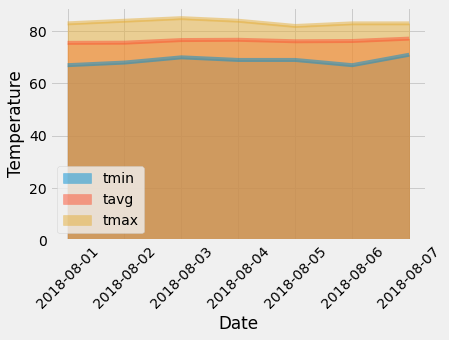

In [22]:
# Plot the daily normals as an area plot with `stacked=False`
trip_temps.plot(kind='area', stacked=False)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.xticks(rotation=45)
plt.show()

In [23]:
## Close Session
session.close()